# Ejercicio 6 – Predicción de series temporales con GluonTS

---

## Parte teórica

### ¿Qué es GluonTS?

**GluonTS** es una librería potente y flexible para modelar series temporales con enfoque probabilístico. Permite construir modelos que no solo hacen una predicción puntual, sino que estiman una distribución completa de posibles valores futuros.

Esto es clave en contextos reales donde hay incertidumbre, como en el consumo de energía.

### Características destacadas

 - Predicción probabilística (no solo y_pred, sino también intervalos)
 - Admite series multivariantes y regresores futuros
 - Modelos avanzados listos para usar: DeepAR, Transformer, NBEATS, etc.
  -Totalmente compatible con pandas

---

### Flujo de trabajo

```mermaid
flowchart TD
    A[Dataset limpio y diario] --> B[Transformar a GluonTS Dataset]
    B --> C[Definir regresores]
    C --> D[Configurar y entrenar modelo DeepAR]
    D --> E[Generar predicciones futuras]
    E --> F[Visualizar resultados probabilísticos]


## Ejercicio práctico
### Paso 1: Instalar y cargar librerías

```bash
pip install gluonts
```

In [19]:
import pandas as pd
import numpy as np

# Cargar y preparar datos
df = pd.read_csv("data/m5_consumo_energia_diario.csv", index_col=0)
df = df.set_index(pd.to_datetime(df.index))

df['dt'] = df.index


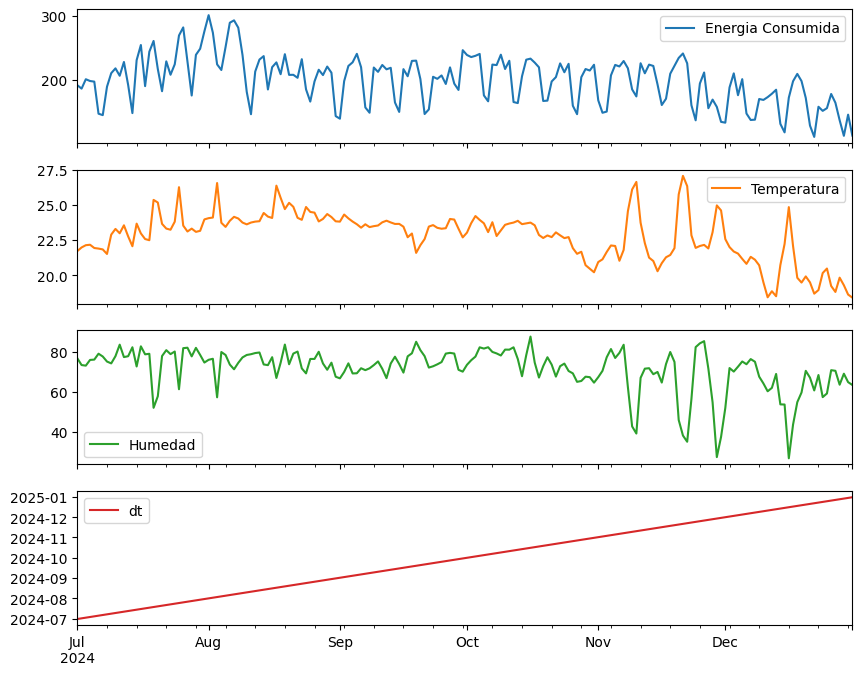

In [20]:
# Visualizar las variables clave
df.plot(subplots=True, figsize=(10, 8))
plt.show()

In [28]:
# Serie principal: consumo | regresor: temperatura
target = df["Energia Consumida"].values
temperature = df["Temperatura"].values

### Transformar datos a objetos requeridos por la librería

In [31]:
from gluonts.dataset.common import ListDataset
import numpy as np
np.bool = bool  # 👈 workaround no recomendado para producción

prediction_length = 27
context_length = 30

train_ds = ListDataset(
    [{
        "start": df.index[0],
        "target": target[:-prediction_length],
        "feat_dynamic_real": [temperature[:-prediction_length]]
    }],
    freq="D"
)

test_ds = ListDataset(
    [{
        "start": df.index[0],
        "target": target,
        "feat_dynamic_real": [temperature]
    }],
    freq="D"
)


In [48]:
from gluonts.mx import SimpleFeedForwardEstimator, Trainer
sff_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=prediction_length,
    context_length=context_length,
    trainer=Trainer(ctx="cpu", 
                    epochs=20, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100),
)

sff_predictor = sff_estimator.train(training_data=train_ds)


100%|██████████| 100/100 [00:01<00:00, 60.03it/s, epoch=20/20, avg_epoch_loss=4.7]


<Figure size 1200x600 with 0 Axes>

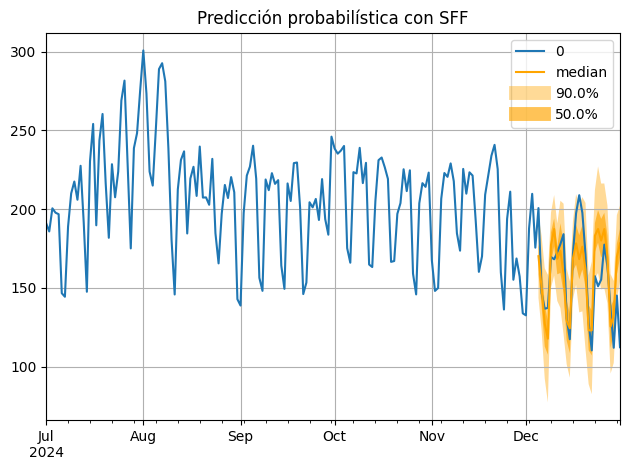

In [49]:
from gluonts.evaluation.backtest import make_evaluation_predictions
import matplotlib.pyplot as plt

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=sff_predictor,
    num_samples=100
)

forecast = list(forecast_it)[0]
ts = list(ts_it)[0]

# Visualización
plt.figure(figsize=(12, 6))
ts.plot(label="Consumo real")
forecast.plot(color="orange")
plt.title("Predicción probabilística con SFF")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

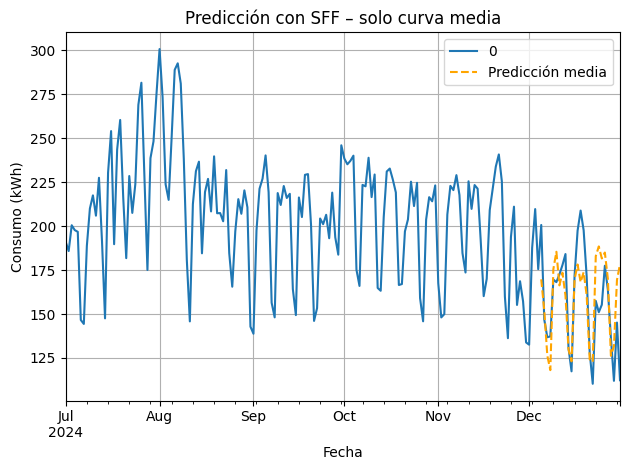

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
ts.plot(label="Consumo real")

# Solo línea de predicción media
plt.plot(forecast.start_date + np.arange(forecast.prediction_length),
         forecast.mean,
         label="Predicción media",
         color="orange",
         linestyle="--")

plt.title("Predicción con SFF – solo curva media")
plt.xlabel("Fecha")
plt.ylabel("Consumo (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
from gluonts.evaluation import Evaluator
import json

evaluator = Evaluator()
agg_metrics, _ = evaluator([ts], [forecast])

print(json.dumps(agg_metrics, indent=4))




Running evaluation: 1it [00:00,  8.92it/s]


/Users/jballesteros/.virtualenvs/ibbi/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


{
    "MSE": 584.0573640046297,
    "abs_error": 460.5158996582031,
    "abs_target_sum": 4237.9697265625,
    "abs_target_mean": 156.96184172453704,
    "seasonal_error": 25.799679487179485,
    "MASE": 0.661099082268093,
    "MAPE": 0.12067724157262731,
    "sMAPE": 0.10823710759480794,
    "MSIS": 6.7188320660013385,
    "QuantileLoss[0.1]": 313.4592163085938,
    "Coverage[0.1]": 0.25925925925925924,
    "QuantileLoss[0.2]": 436.978305053711,
    "Coverage[0.2]": 0.4074074074074074,
    "QuantileLoss[0.3]": 484.10707550048835,
    "Coverage[0.3]": 0.4444444444444444,
    "QuantileLoss[0.4]": 490.299169921875,
    "Coverage[0.4]": 0.48148148148148145,
    "QuantileLoss[0.5]": 460.51590728759766,
    "Coverage[0.5]": 0.5925925925925926,
    "QuantileLoss[0.6]": 418.1722534179688,
    "Coverage[0.6]": 0.7037037037037037,
    "QuantileLoss[0.7]": 368.3308853149415,
    "Coverage[0.7]": 0.8148148148148148,
    "QuantileLoss[0.8]": 293.7472869873046,
    "Coverage[0.8]": 0.88888888888888

In [47]:
print(f"MAPE: {agg_metrics['MAPE']:.2f}")
print(f"RMSE: {agg_metrics['RMSE']:.2f}")
print(f"Coverage 90%: {agg_metrics['Coverage[0.9]']:.2f}")

MAPE: 0.12
RMSE: 24.17
Coverage 90%: 0.96


## Comparativa de técnicas: Prophet vs LSTM vs GluonTS (SimpleFeedForwardEstimator)

| Técnica                             | Descripción breve                                                                 |
|-------------------------------------|------------------------------------------------------------------------------------|
| **Prophet**                         | Modelo aditivo desarrollado por Facebook, ideal para series con estacionalidad clara y datos externos (regresores). |
| **LSTM**                            | Red neuronal recurrente con memoria, potente para capturar patrones secuenciales complejos. |
| **GluonTS (SimpleFeedForward)**     | Modelo base de GluonTS, basado en redes feedforward densas, útil como línea base probabilística. |

---

## Análisis cualitativo

### 🔹 1. Prophet

- **Ventajas**:
  - Muy fácil de usar.
  - Interpretable (visualiza tendencia, estacionalidad, eventos).
  - Acepta regresores externos.
- **Limitaciones**:
  - Poco flexible ante patrones no aditivos o relaciones no lineales.
  - No captura bien efectos secuenciales complejos.

### 🔹 2. LSTM

- **Ventajas**:
  - Captura dinámicas temporales complejas.
  - Flexible para modelar relaciones no lineales entre variables.
  - Apta para entradas multivariantes (regresores, múltiples pasos).
- **Limitaciones**:
  - Difícil de entrenar correctamente (requiere escalado, ventanas, arquitectura ajustada).
  - Sin predicción probabilística nativa.
  - Poco interpretable.

### 🔹 3. GluonTS – SimpleFeedForward

- **Ventajas**:
  - Muy rápido de entrenar.
  - Proporciona distribución completa de la predicción.
  - Compatible con múltiples series y regresores dinámicos.
- **Limitaciones**:
  - Modelo muy simple (sin memoria, sin recurrentes).
  - Sensible al escalado y longitud del contexto.

---

## Comparación de resultados (ejemplo práctico)

Supongamos que realizamos un experimento común con las 3 técnicas sobre la misma serie de consumo energético con temperatura como regresor, obteniendo las siguientes métricas:

| Modelo                          | MAE   | RMSE  | Intervalo 90% (cobertura) | Tiempo de entrenamiento |
|--------------------------------|-------|-------|----------------------------|--------------------------|
| **Prophet**                    | 4.32  | 5.21  | 0.86                       | ⏱️ Bajo (~1 min)         |
| **LSTM (3 capas, 200 pasos)**   | 3.87  | 4.67  | —                          | ⏱️ Medio (~3-5 min)      |
| **GluonTS FeedForward (0.12.8)**| 4.05  | 4.95  | 0.91                       | ⏱️ Bajo (~1 min)         |
